# Exploratory Data Analysis
---

**Objective:** Understand the variables, association between them and necessary transformations before model selection/building.

**Process:**
1. Importing libraries and dataset
2. Checking data types, nulls and outliers
3. Univariate analysis (target)
4. Bivariate analysis (relation to target)
5. Multivariate analysis (multicollinearity)
---

## 1. Importing libraries and dataset

In [33]:
# Adding src to the path for modules
import sys
import os
root_path = os.path.abspath('..')
src_path = os.path.join(root_path, 'src')
sys.path.append(src_path)

# Data Manipulation
import pandas as pd
import numpy as np

# Hypothesis Test
import scipy.stats as stats

# Data Viz
import matplotlib.pyplot as plt
import seaborn as sns

# Project variables and functions
import config 
import utils
import importlib
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\vsuar\\OneDrive\\Documentos\\IncomePrediction\\src\\utils.py'>

Importing the data and having a first look at it:

In [34]:
# Importing
df = utils.read_compressed_data(config.COLLECTED_DATA_PATH)

# First look
df.sample(10)

,year,quarter,state,age,sex,race,literate,highest_educational_level,years_studied,worker_type,work_segment,occupation_group,tax_payer,weekly_worked_hours,main_work_income,all_work_income,weekly_worked_hours_all_jobs
1215810,2023,3,PA,52,1,2,1,2,6,1,7,3,1,3,1320.0,1320.0,44
1451496,2022,1,RS,58,1,1,1,2,6,1,5,8,1,5,4000.0,4000.0,50
1345647,2023,1,GO,52,1,4,2,2,2,9,5,8,2,4,3000.0,3000.0,48
1097447,2022,1,RO,53,2,4,1,7,16,7,9,2,1,3,3000.0,3000.0,40
215172,2021,2,MG,53,2,4,1,5,12,1,4,7,1,3,1100.0,1100.0,44
873891,2021,1,PR,42,2,1,1,7,16,7,9,2,1,5,2000.0,4600.0,60
1042053,2021,3,MT,34,1,4,1,5,12,1,2,3,1,2,3000.0,3000.0,24
184220,2023,4,MA,35,1,4,2,1,0,2,1,6,2,5,605.0,605.0,60
1521830,2023,4,PB,35,2,1,1,7,16,1,7,4,1,3,2400.0,2400.0,40
60992,2022,1,MA,37,2,4,1,7,16,7,9,3,1,3,1800.0,1800.0,40


---
## 2. Checking data types, nulls and outliers

Checking types:

In [35]:
# Types
df.dtypes

year                              int64
quarter                           int64
state                            object
age                               int64
sex                               int64
race                              int64
literate                          int64
highest_educational_level         int64
years_studied                     int64
worker_type                       int64
work_segment                      int64
occupation_group                  int64
tax_payer                         int64
weekly_worked_hours               int64
main_work_income                float64
all_work_income                 float64
weekly_worked_hours_all_jobs      int64
dtype: object

Although almost all columns are codified as numeric, most of them are truly categorical.    
The ones that are numeric should be stored in a separate variable.

In [36]:
truly_numeric = ['year', 'quarter', 'age', 'years_studied', 'main_work_income', 'all_work_income']

Checking nulls:

In [37]:
# Nulls
utils.nulls_percentage(df)

Null Percentage by Column: 


year                             0.00%
worker_type                      0.00%
all_work_income                  0.00%
main_work_income                 0.00%
weekly_worked_hours              0.00%
tax_payer                        0.00%
occupation_group                 0.00%
work_segment                     0.00%
years_studied                    0.00%
quarter                          0.00%
highest_educational_level        0.00%
literate                         0.00%
race                             0.00%
sex                              0.00%
age                              0.00%
state                            0.00%
weekly_worked_hours_all_jobs     0.00%
dtype: object

Checking outliers:

In [24]:
utils.outlier_percentage(df[truly_numeric])

Percentage of Outliers per Column: 


,Inner Fence,Outer Fence
year,0.00%,0.00%
quarter,0.00%,0.00%
age,0.07%,0.00%
years_studied,3.07%,0.00%
main_work_income,10.46%,5.56%
all_work_income,11.06%,5.94%


Inner Fence showed itself to be a lot more sensitive to outliers.   
Using outer fence keeps roughly 95% of income as it is right now, and probably will be the preferred method.   
I'll check the description to understand where these outliers may be.

In [7]:
utils.formatted_description(df[truly_numeric])

,year,quarter,age,years_studied,main_work_income,all_work_income
mean,2022.1,2.6,40.7,10.7,2417.7,2489.3
std,0.8,1.1,13.5,4.3,3660.5,3894.9
min,2021.0,1.0,14.0,0.0,2.0,2.0
25%,2021.0,2.0,30.0,8.0,1100.0,1100.0
50%,2022.0,3.0,40.0,12.0,1500.0,1500.0
75%,2023.0,4.0,51.0,13.0,2500.0,2500.0
max,2023.0,4.0,114.0,16.0,300000.0,900000.0


Doing a quick math, I see that inner fence was more sensitive to rows with few years studied and high income.    
I consider the intervals to be acceptable and therefore confirm my option for the outer fence method for dealing with outliers. 

----
## 3. Univariate Analysis (Target)

First, it seems that main_work_income is almost always the same as all_work_income.    
I want to quantify how much similiar are they.

In [26]:
main_is_all = df.loc[df['all_work_income']==df['main_work_income']].shape[0] / df.shape[0]
print(f'Propostion of rows where main income represents all income: {main_is_all * 100 :.2f}%')

Propostion of rows where main income represents all income: 96.99%


Although they are roughly 97% of time the same, I'll use the all_work_income column for the analysis/prediction. 

Treating outliers:

In [38]:
print('Max before winsorization:', df['all_work_income'].max())
df['all_work_income'] = utils.winsorizing_outliers(df['all_work_income'])
print('Max after winsorization:', df['all_work_income'].max())

Max before winsorization: 900000.0
Max after winsorization: 6700.0


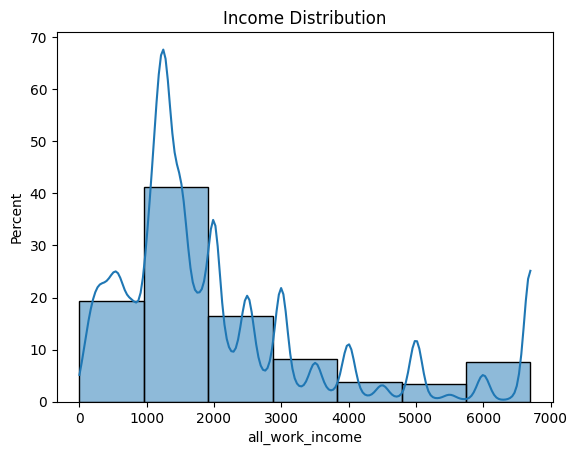

In [12]:
sns.histplot(df['all_work_income'], kde=True, stat='percent', binwidth=1000)
plt.title('Income Distribution')
plt.show()